# Carico il df di c-MYC completo:

['Temperatura', 'Cp_corretto', 'Cp_normalizzato']


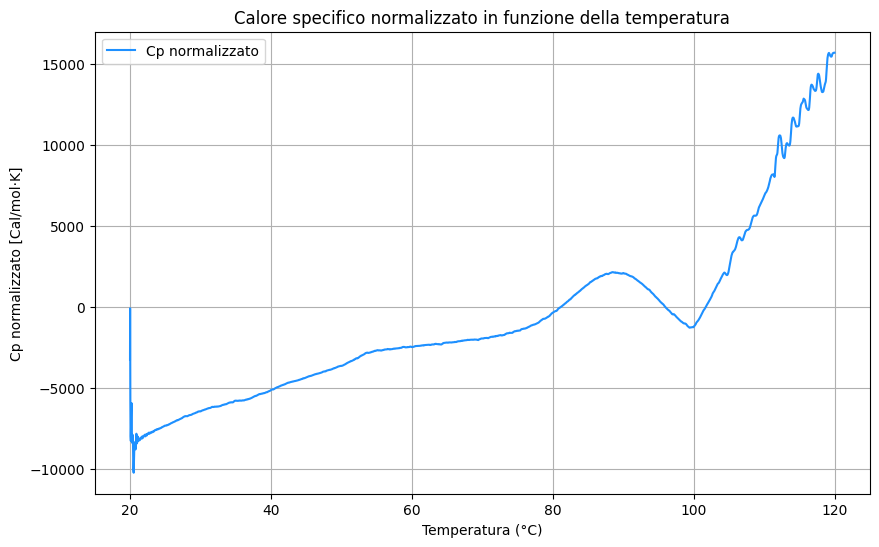

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import linregress
from scipy.interpolate import interp1d

# === Carica il file CSV ===
df_corr = pd.read_csv("df_corr_completo.csv", sep="\t", )

print(df_corr.columns.tolist())

plt.figure(figsize=(10, 6))
# === Grafico Cp normalizzato in funzione della temperatura ===
plt.plot(df_corr["Temperatura"], df_corr["Cp_normalizzato"], label="Cp normalizzato", color='dodgerblue')
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp normalizzato [Cal/mol·K]")
plt.title("Calore specifico normalizzato in funzione della temperatura")
plt.grid(True)
plt.legend()
plt.show()

# Estrazione picchi:

## Estrazione di 2 picchi che corrispondono a 2 transizioni:

Se si osserva bene l'andamento di Cp normalizzato si intuisce che le discontinuità del segnale sono presenti in due punti: 
1. Intorno ai 50°C;
2. Intorno a 90°C dove effettivamente, fin ora, è stato estratto il picco.
La discontinuità trovata a T inferiore si pensa sia dovuta ad una transizione conformazionale e non propriamente chimica (permetterebbe di spiegare il picco di gran lunga meno marcato), e si è deciso per tanto, di analizzare meglio questo fenomeno che è pienamente concorde con i risultati estratti dall'esperimento di Circoular Dichroism.

A tal fine, ora si andranno ad effettuare ulteriormente due fit:
- Il primo globale da cui poi si estrarranno le aree sottese ad entrambi i fit;
- Il secondo, invece, sarà basato su una divisione empirica del dataframe così da usare curve più basilari per la sottrazione della baseline.

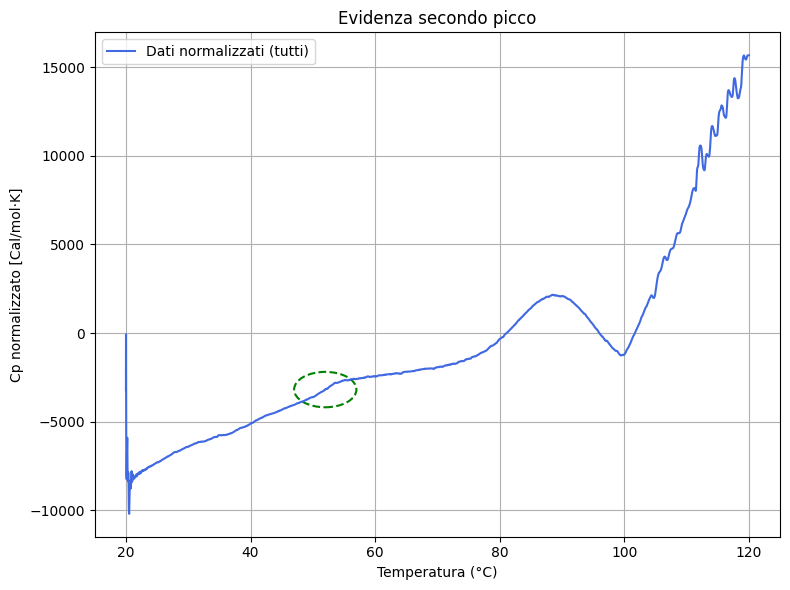

In [35]:
from matplotlib import patches

# Interpolazione Cp_normalizzato in funzione della Temperatura
interp_Cp = interp1d(df_corr["Temperatura"], df_corr["Cp_normalizzato"], kind='linear', fill_value="extrapolate")

# --- Centro orizzontale (gradi Celsius) ---
center_x = 52
half_width = 5
width = 2 * half_width
height = 2000  # Cp vertical span
center_y = float(interp_Cp(center_x))  # Cp a 52 °C


# --- Plot completo ---
plt.figure(figsize=(8, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_normalizzato"], label="Dati normalizzati (tutti)", color='royalblue')

# --- Ellisse centrata esattamente sul valore della curva a 52 °C ---
ellipse = patches.Ellipse(
    (center_x, center_y),
    width=width,
    height=height,
    linewidth=1.5,
    edgecolor='green',
    facecolor='none',
    linestyle='--'
)
plt.gca().add_patch(ellipse)

plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp normalizzato [Cal/mol·K]")
plt.title("Evidenza secondo picco")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**1° fit**

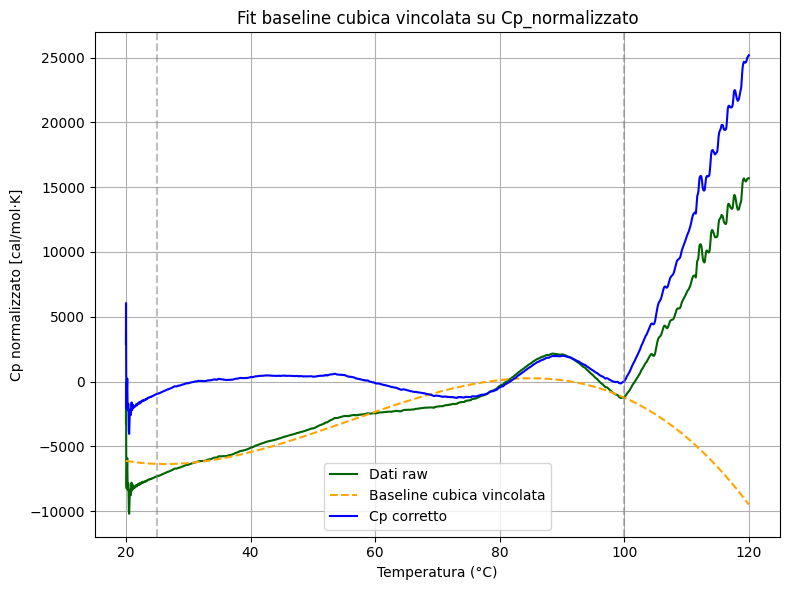

In [36]:


# === Estrai e filtra i dati nel range desiderato ===
df_fit = df_corr[(df_corr["Temperatura"] >= 25) & (df_corr["Temperatura"] <= 100)].copy()

T = df_fit["Temperatura"].values
Cp = df_fit["Cp_normalizzato"].values

# === Punto finale vincolato ===
T_end = T[-1]
Cp_end = Cp[-1]

# === Funzione cubica vincolata a passare per (T_end, Cp_end) ===
def baseline_cubica_vincolata(T, a, b, c):
    d = Cp_end - (a*T_end**3 + b*T_end**2 + c*T_end)
    return a*T**3 + b*T**2 + c*T + d

# === Fit della baseline cubica ===
popt_cubic, _ = curve_fit(baseline_cubica_vincolata, T, Cp)

# === Applica il fit all'intero range per il grafico finale ===
T_full = df_corr["Temperatura"].values
Cp_baseline = baseline_cubica_vincolata(T_full, *popt_cubic)

# === Salva nel DataFrame originale ===
df_corr["Cp_baseline_cubica"] = Cp_baseline
df_corr["Cp_finale_cubica"] = df_corr["Cp_normalizzato"] - df_corr["Cp_baseline_cubica"]

# === Plot per visualizzare ===
plt.figure(figsize=(8, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_normalizzato"], label="Dati raw", color='darkgreen')
plt.plot(df_corr["Temperatura"], df_corr["Cp_baseline_cubica"], '--', label="Baseline cubica vincolata", color='orange')
plt.plot(df_corr["Temperatura"], df_corr["Cp_finale_cubica"], label="Cp corretto", color='blue')
plt.axvline(25, color='gray', linestyle='--', alpha=0.5)
plt.axvline(100, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp normalizzato [cal/mol·K]")
plt.title("Fit baseline cubica vincolata su Cp_normalizzato")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Correzione della baseline tramite interpolazione cubica vincolata con penalità

Per correggere la baseline del segnale calorimetrico e isolare i contributi cooperativi all’aumento di capacità termica, è stato effettuato un fit cubico della forma:

$$
Cp_{\text{baseline}}(T) = aT^3 + bT^2 + cT + d
$$

Il termine $d$ è stato calcolato imponendo il vincolo che la curva passi per il punto finale dei dati selezionati $(T_{\text{end}}, Cp_{\text{end}})$, ovvero:

$$
d = Cp_{\text{end}} - (aT_{\text{end}}^3 + bT_{\text{end}}^2 + cT_{\text{end}})
$$

Tuttavia, un semplice fit cubico teso a rispettare solo questo vincolo portava a una forma non fisicamente compatibile con i dati: la curva interpolante superava visibilmente i valori sperimentali nel dominio centrale, alterando la forma dei picchi.

Per questo motivo si è introdotta una **funzione obiettivo penalizzata**, definita come:

$$
L(a, b, c) = \frac{1}{N} \sum_i \left[ (Cp_i - Cp_{\text{baseline}}(T_i))^2 + \lambda \cdot \Theta(Cp_{\text{baseline}}(T_i) - Cp_i) \cdot (Cp_{\text{baseline}}(T_i) - Cp_i)^2 \right]
$$

dove $\Theta$ è la funzione di Heaviside (vale 1 solo quando $Cp_{\text{baseline}} > Cp$), e $\lambda$ è un fattore di penalità (in questo caso $\lambda = 10$).

L'ottimizzazione dei coefficienti $a, b, c$ è stata eseguita tramite il metodo **L-BFGS-B**, vincolando i coefficienti a rientrare in un intervallo finito per evitare soluzioni instabili. In questo modo, la baseline risulta più aderente ai dati senza sopravvalutarli, mantenendo la chiusura finale e migliorando la qualità della correzione.


#### Comportamento della funzione di penalità

La penalizzazione è **attiva solo se** la baseline eccede il dato, ovvero quando $Cp_{\text{baseline}}(T_i) > Cp_i$.

In questo caso:
$$
\Theta = 1 \quad \Rightarrow \quad \text{l’errore quadratico viene moltiplicato per } \lambda
$$

Viceversa, se la baseline è al di sotto dei dati ($Cp_{\text{baseline}} \leq Cp$), $\Theta = 0$ e il termine penalizzante scompare.

#### Effetto sull’ottimizzazione

La presenza della penalità introduce un asimmetria nella funzione obiettivo:  
- gli errori **in eccesso** (baseline sopra i dati) pesano molto di più
- gli errori **in difetto** (baseline sotto i dati) non sono penalizzati aggiuntivamente

Questo induce l’ottimizzatore a **preferire soluzioni in cui la baseline si adagia sotto ai dati**, evitando di interferire con i picchi del segnale calorimetrico.

#### Conclusione

Questa tecnica consente di:
- **evitare sovrastime spurie** di $\Delta H$
- **preservare la struttura dei picchi**
- **garantire la chiusura finale** vincolando la baseline all’ultimo punto $(T_{\text{end}}, Cp_{\text{end}})$

È quindi particolarmente utile in esperimenti DSC in cui i picchi sono ben definiti ma la baseline può mostrare curvature ampie e non banali.

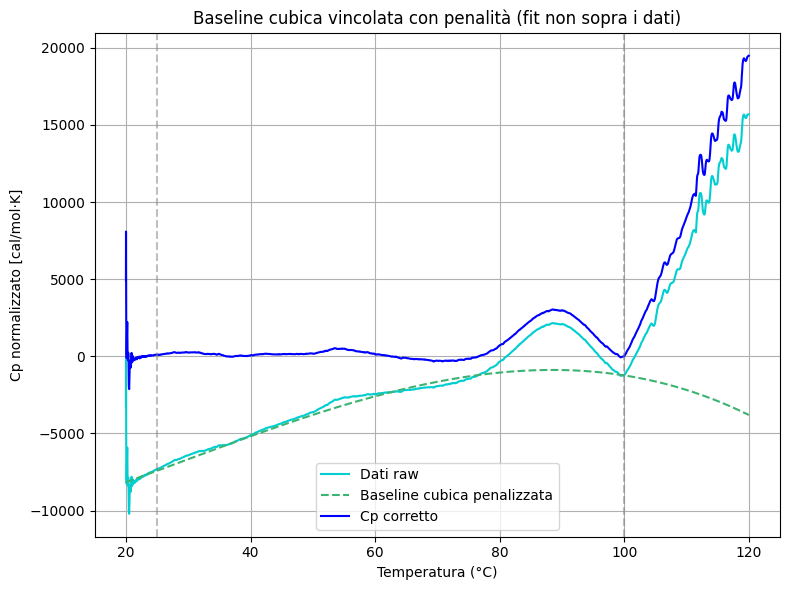

In [37]:
# === Dati filtrati per fit ===
df_fit = df_corr[(df_corr["Temperatura"] >= 25) & (df_corr["Temperatura"] <= 100)].copy()
T = df_fit["Temperatura"].values
Cp = df_fit["Cp_normalizzato"].values

# Punto finale per il vincolo
T_end = T[-1]
Cp_end = Cp[-1]

# === Funzione baseline cubica vincolata (d calcolato per chiudere al punto finale) ===
def cubica_vincolata(T, a, b, c):
    d = Cp_end - (a*T_end**3 + b*T_end**2 + c*T_end)
    return a*T**3 + b*T**2 + c*T + d

# === Funzione di loss penalizzata se il fit va sopra i dati ===
def penalized_loss(params):
    a, b, c = params
    baseline = cubica_vincolata(T, a, b, c)
    diff = Cp - baseline
    penalty = np.where(diff < 0, 10 * diff**2, diff**2)  # penalizza solo se baseline > Cp
    return np.mean(penalty)

# === Ottimizzazione con bound moderati su coefficenti ===
result = minimize(
    penalized_loss,
    x0=[0, 0, 0],  # guess iniziale
    bounds=[(-1, 1), (-10, 10), (-1e3, 1e3)],  # aggiusta a piacere
    method='L-BFGS-B'
)

# === Calcola la baseline finale ===
a_opt, b_opt, c_opt = result.x
T_full = df_corr["Temperatura"].values
Cp_baseline = cubica_vincolata(T_full, a_opt, b_opt, c_opt)

df_corr["Cp_baseline_cubica"] = Cp_baseline
df_corr["Cp_finale_cubica"] = df_corr["Cp_normalizzato"] - df_corr["Cp_baseline_cubica"]

# === Plot ===
plt.figure(figsize=(8, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_normalizzato"], label="Dati raw", color='darkturquoise')
plt.plot(df_corr["Temperatura"], df_corr["Cp_baseline_cubica"], '--', label="Baseline cubica penalizzata", color='mediumseagreen')
plt.plot(df_corr["Temperatura"], df_corr["Cp_finale_cubica"], label="Cp corretto", color='blue')
plt.axvline(25, color='gray', linestyle='--', alpha=0.5)
plt.axvline(100, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp normalizzato [cal/mol·K]")
plt.title("Baseline cubica vincolata con penalità (fit non sopra i dati)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


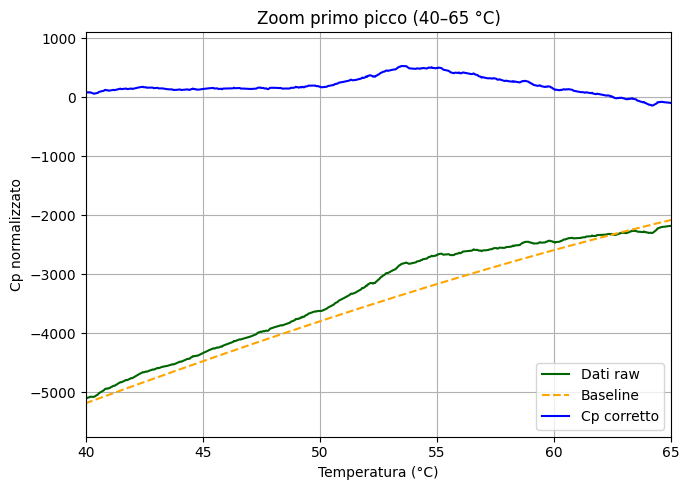

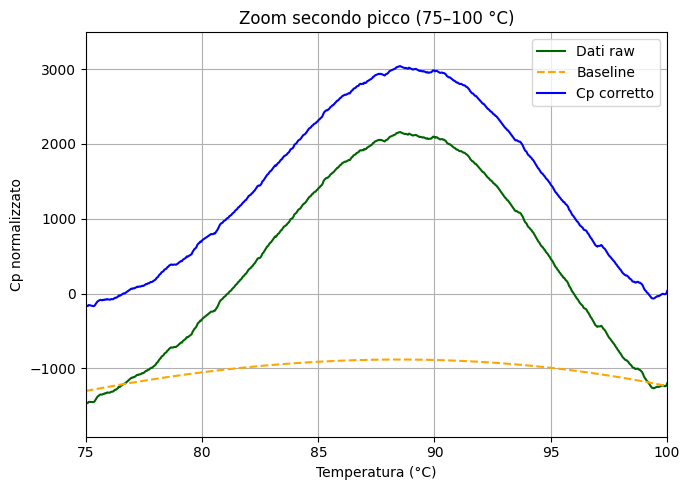

In [38]:
def plot_zoom(df, xmin, xmax, title):
    df_zoom = df[(df["Temperatura"] >= xmin) & (df["Temperatura"] <= xmax)]
    ymin = df_zoom[["Cp_normalizzato", "Cp_baseline_cubica", "Cp_finale_cubica"]].min().min()
    ymax = df_zoom[["Cp_normalizzato", "Cp_baseline_cubica", "Cp_finale_cubica"]].max().max()
    margin = 0.1 * (ymax - ymin)

    plt.figure(figsize=(7, 5))
    plt.plot(df["Temperatura"], df["Cp_normalizzato"], label="Dati raw", color='darkgreen')
    plt.plot(df["Temperatura"], df["Cp_baseline_cubica"], '--', label="Baseline", color='orange')
    plt.plot(df["Temperatura"], df["Cp_finale_cubica"], label="Cp corretto", color='blue')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin - margin, ymax + margin)
    plt.title(title)
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Cp normalizzato")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Primo picco
plot_zoom(df_corr, 40, 65, "Zoom primo picco (40–65 °C)")

# Secondo picco
plot_zoom(df_corr, 75, 100, "Zoom secondo picco (75–100 °C)")


**2° Fit spezzato della baseline**

La baseline è stata corretta con due rette vincolate nei tratti 25–70 °C e 70–100 °C, imponendo il passaggio per i valori estremi.  
Questo approccio evita flessioni spurie e mantiene la continuità al punto di raccordo (70 °C).


In [39]:
def baseline_lineare_vincolata(T, T_start, T_end, Cp_start, Cp_end):
    """
    Fit lineare vincolato agli estremi noti (x0,y0) e (x1,y1).
    """
    m = (Cp_end - Cp_start) / (T_end - T_start)
    q = Cp_start - m * T_start
    return m * T + q


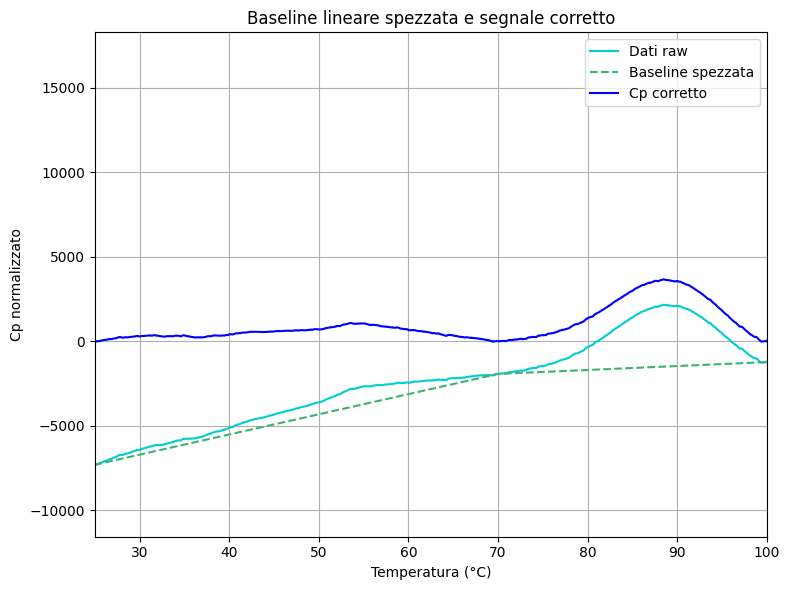

In [40]:
# --- Maschera completa ---
mask_tot = (df_corr["Temperatura"] >= 25) & (df_corr["Temperatura"] <= 100)
df_masked = df_corr[mask_tot].copy()

# --- Maschera spezzata ---
mask1 = (df_masked["Temperatura"] >= 25) & (df_masked["Temperatura"] <= 70)
mask2 = (df_masked["Temperatura"] > 70) & (df_masked["Temperatura"] <= 100)

T1 = df_masked.loc[mask1, "Temperatura"].values
T2 = df_masked.loc[mask2, "Temperatura"].values

Cp1 = df_masked.loc[mask1, "Cp_normalizzato"].values
Cp2 = df_masked.loc[mask2, "Cp_normalizzato"].values

# --- Estremi vincolati ---
T_25 = T1[0]
Cp_25 = Cp1[0]

T_70 = T1[-1]
Cp_70 = Cp1[-1]

T_100 = T2[-1]
Cp_100 = Cp2[-1]

# --- Fit lineari vincolati ---
Cp_baseline1 = baseline_lineare_vincolata(T1, T_25, T_70, Cp_25, Cp_70)
Cp_baseline2 = baseline_lineare_vincolata(T2, T_70, T_100, Cp_70, Cp_100)

# --- Costruisci baseline completa ---
Cp_baseline_spezzata = np.concatenate([Cp_baseline1, Cp_baseline2])
T_spezzato = np.concatenate([T1, T2])

# --- Costruisci baseline su tutto il range -------------------------
T_full = df_corr["Temperatura"].values

Cp_baseline_estesa = np.full_like(T_full, np.nan, dtype=float)

# Ricostruzione della baseline su tutto il range
Cp_baseline_estesa[(T_full >= 25) & (T_full <= 70)]  = baseline_lineare_vincolata(
    T_full[(T_full >= 25) & (T_full <= 70)], T_25, T_70, Cp_25, Cp_70)

Cp_baseline_estesa[(T_full > 70) & (T_full <= 100)] = baseline_lineare_vincolata(
    T_full[(T_full > 70) & (T_full <= 100)], T_70, T_100, Cp_70, Cp_100)

# Fuori dai limiti: mantieni costante ai bordi
Cp_baseline_estesa[T_full < 25]  = Cp_25
Cp_baseline_estesa[T_full > 100] = Cp_100

# --- Salva nel DataFrame completo ---
df_corr["Cp_baseline_spezzata"] = Cp_baseline_estesa
df_corr["Cp_finale_spezzata"]   = df_corr["Cp_normalizzato"] - Cp_baseline_estesa



plt.figure(figsize=(8, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_normalizzato"], label="Dati raw", color='darkturquoise')
plt.plot(df_corr["Temperatura"], df_corr["Cp_baseline_spezzata"], '--', label="Baseline spezzata", color='mediumseagreen')
plt.plot(df_corr["Temperatura"], df_corr["Cp_finale_spezzata"], label="Cp corretto", color='blue')
plt.xlim(25, 100)
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp normalizzato")
plt.title("Baseline lineare spezzata e segnale corretto")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


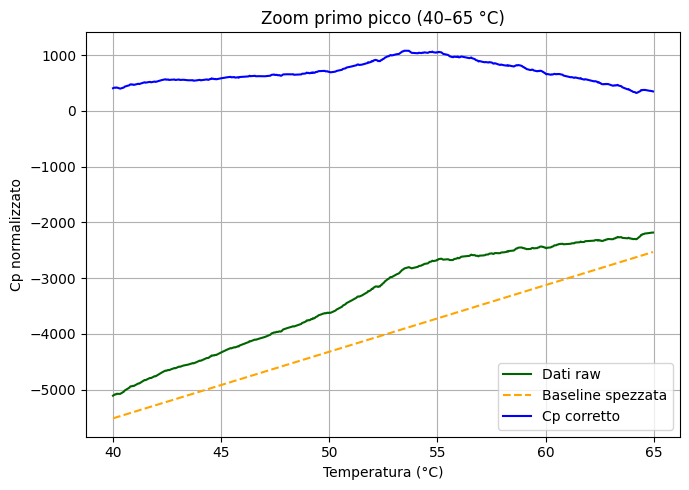

In [41]:
mask_zoom1 = (df_corr["Temperatura"] >= 40) & (df_corr["Temperatura"] <= 65)
df_zoom1 = df_corr[mask_zoom1]

plt.figure(figsize=(7, 5))
plt.plot(df_zoom1["Temperatura"], df_zoom1["Cp_normalizzato"], label="Dati raw", color='darkgreen')
plt.plot(df_zoom1["Temperatura"], df_zoom1["Cp_baseline_spezzata"], '--', label="Baseline spezzata", color='orange')
plt.plot(df_zoom1["Temperatura"], df_zoom1["Cp_finale_spezzata"], label="Cp corretto", color='blue')
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp normalizzato")
plt.title("Zoom primo picco (40–65 °C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


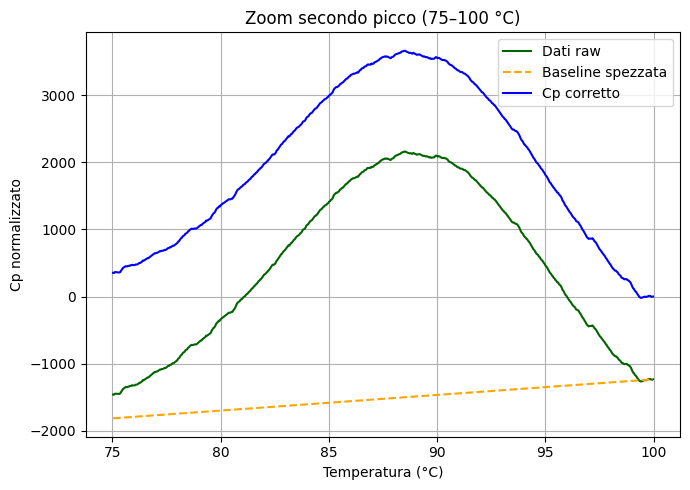

In [42]:
mask_zoom2 = (df_corr["Temperatura"] >= 75) & (df_corr["Temperatura"] <= 100)
df_zoom2 = df_corr[mask_zoom2]

plt.figure(figsize=(7, 5))
plt.plot(df_zoom2["Temperatura"], df_zoom2["Cp_normalizzato"], label="Dati raw", color='darkgreen')
plt.plot(df_zoom2["Temperatura"], df_zoom2["Cp_baseline_spezzata"], '--', label="Baseline spezzata", color='orange')
plt.plot(df_zoom2["Temperatura"], df_zoom2["Cp_finale_spezzata"], label="Cp corretto", color='blue')
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp normalizzato")
plt.title("Zoom secondo picco (75–100 °C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Fit di Van't Hoff e Gauss per i due set di dati:

## Primo dataset (fit globale):

In [43]:
df_corr.head()

,Temperatura,Cp_corretto,Cp_normalizzato,Cp_baseline_cubica,Cp_finale_cubica,Cp_baseline_spezzata,Cp_finale_spezzata
0,20.003,-0.301771,-3218.891220,-8160.515862,4941.624642,-7306.125876,4087.234655
1,20.018,-0.006626,-70.680655,-8158.300845,8087.620190,-7306.125876,7235.445221
2,20.050,-0.530984,-5663.831449,-8153.574957,2489.743508,-7306.125876,1642.294427
3,20.084,-0.745989,-7957.220834,-8148.552932,191.332098,-7306.125876,-651.094959
4,20.124,-0.773937,-8255.325994,-8142.643656,-112.682338,-7306.125876,-949.200118


### Primo picco:

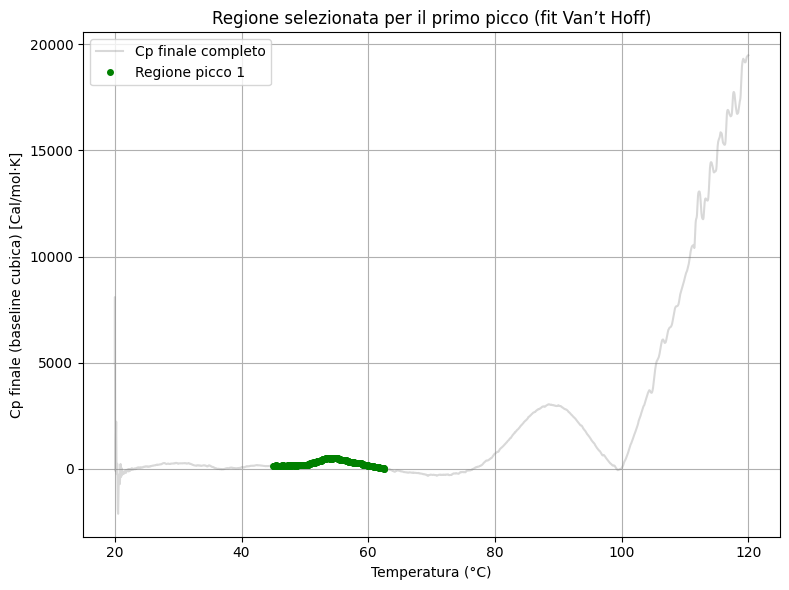

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Estrai dati filtrati (baseline cubica già sottratta)
mask1 = (df_corr["Temperatura"] >= 45) & (df_corr["Temperatura"] <= 62.5)
T1 = df_corr.loc[mask1, "Temperatura"].values + 273.15  # in Kelvin
Cp1 = df_corr.loc[mask1, "Cp_finale_cubica"].values

# Plot per controllo
plt.figure(figsize=(8, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_finale_cubica"], color='gray', alpha=0.3, label='Cp finale completo')
plt.plot(T1 - 273.15, Cp1, 'o', color='green', markersize=4, label='Regione picco 1')
plt.title("Regione selezionata per il primo picco (fit Van’t Hoff)")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp finale (baseline cubica) [Cal/mol·K]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Fit Van't Hoff:

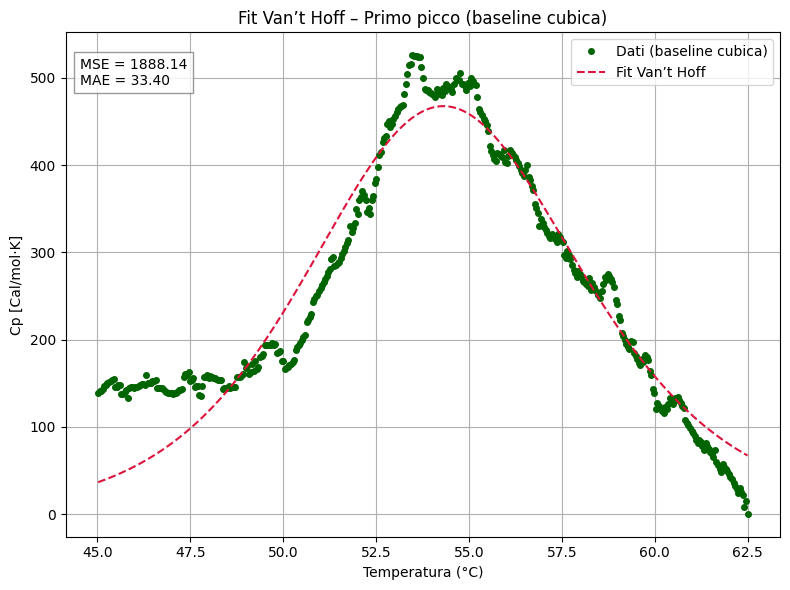

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

R = 1.987  # cal/mol·K

# --- Modello Van’t Hoff ---
def model_vH(T, DH, Tm, Cp_max):
    exponent = -DH / R * (1/T - 1/Tm)
    exponent = np.clip(exponent, -700, 700)
    K = np.exp(exponent)
    return Cp_max * K / (1 + K)**2

# --- Dati ---
T1 = df_corr.loc[(df_corr["Temperatura"] >= 45) & (df_corr["Temperatura"] <= 62.5), "Temperatura"].values + 273.15
Cp1 = df_corr.loc[(df_corr["Temperatura"] >= 45) & (df_corr["Temperatura"] <= 62.5), "Cp_finale_cubica"].values

# --- Fit ---
p0_vh1 = [30000, 328.15, np.max(Cp1)]
bounds_vh1_c = ([10000, 320, 0], [100000, 340, np.max(Cp1) * 10])
popt_vh1_c, pcov_vh1_c = curve_fit(model_vH, T1, Cp1, p0=p0_vh1, bounds=bounds_vh1_c, maxfev=20000)

# --- Predizione e errori ---
Cp_pred_vh1_c = model_vH(T1, *popt_vh1_c)
mse_vh1_c_vh = mean_squared_error(Cp1, Cp_pred_vh1_c)
mae_vh1_c_vh = mean_absolute_error(Cp1, Cp_pred_vh1_c)

# --- Plot ---
T_fit1_c_vh = np.linspace(T1.min(), T1.max(), 500)
Cp_fit1_c_vh = model_vH(T_fit1_c_vh, *popt_vh1_c)

plt.figure(figsize=(8, 6))
plt.plot(T1 - 273.15, Cp1, 'o', color='darkgreen', markersize=4, label="Dati (baseline cubica)")
plt.plot(T_fit1_c_vh - 273.15, Cp_fit1_c_vh, '--', color='crimson', label="Fit Van’t Hoff")
plt.text(0.02, 0.95, f"MSE = {mse_vh1_c_vh:.2f}\nMAE = {mae_vh1_c_vh:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp [Cal/mol·K]")
plt.title("Fit Van’t Hoff – Primo picco (baseline cubica)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Fit Gauss:

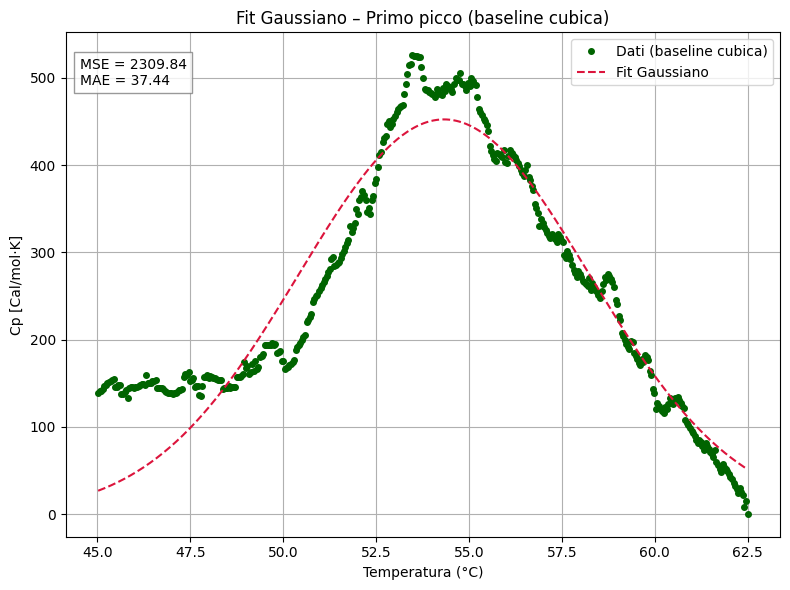

In [46]:
# --- Modello Gaussiano ---
def gaussiana(T, A, mu, sigma):
    return A * np.exp(-((T - mu)**2) / (2 * sigma**2))

# --- Parametri iniziali ---
A0 = np.max(Cp1)
mu0 = T1[np.argmax(Cp1)]
sigma0 = 5

p0_gauss = [A0, mu0, sigma0]
bounds_gauss_c = ([0, mu0 - 10, 1], [A0 * 2, mu0 + 10, 15])

# --- Fit ---
popt_gauss1_c, pcov_gauss1_c = curve_fit(gaussiana, T1, Cp1, p0=p0_gauss, bounds=bounds_gauss_c)

# --- Predizione e errori ---
Cp_pred_gauss1_c = gaussiana(T1, *popt_gauss1_c)
mse_gauss1_c = mean_squared_error(Cp1, Cp_pred_gauss1_c)
mae_gauss1_c = mean_absolute_error(Cp1, Cp_pred_gauss1_c)

# --- Plot ---
T_fit1_c_g = np.linspace(T1.min(), T1.max(), 400)
Cp_fit_gauss1_c_g = gaussiana(T_fit1_c_g, *popt_gauss1_c)

plt.figure(figsize=(8, 6))
plt.plot(T1 - 273.15, Cp1, 'o', color='darkgreen', markersize=4, label="Dati (baseline cubica)")
plt.plot(T_fit1_c_g - 273.15, Cp_fit_gauss1_c_g, '--', color='crimson', label="Fit Gaussiano")
plt.text(0.02, 0.95, f"MSE = {mse_gauss1_c:.2f}\nMAE = {mae_gauss1_c:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp [Cal/mol·K]")
plt.title("Fit Gaussiano – Primo picco (baseline cubica)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Secondo picco:

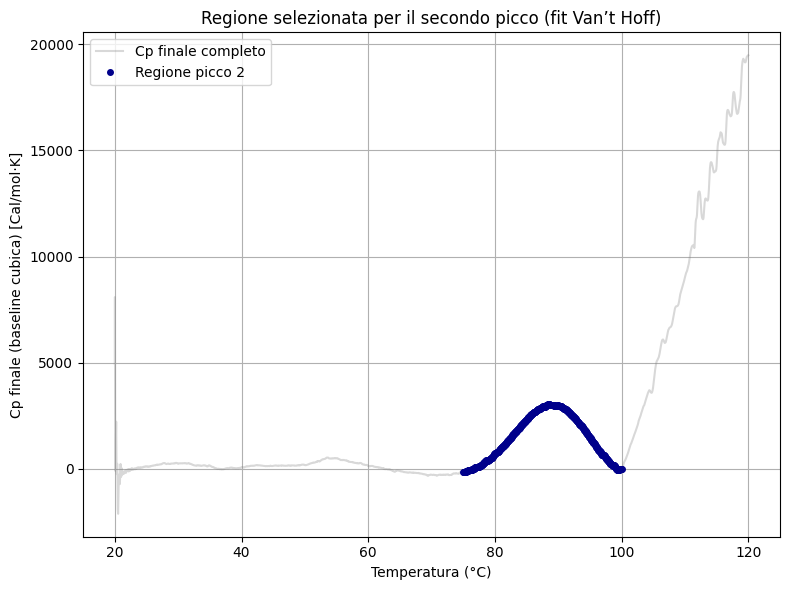

In [47]:
# === Estrai dati filtrati (baseline cubica già sottratta) ===
mask2 = (df_corr["Temperatura"] >= 75) & (df_corr["Temperatura"] <= 100)
T2 = df_corr.loc[mask2, "Temperatura"].values + 273.15  # in Kelvin
Cp2 = df_corr.loc[mask2, "Cp_finale_cubica"].values

# === Plot per controllo ===
plt.figure(figsize=(8, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_finale_cubica"], color='gray', alpha=0.3, label='Cp finale completo')
plt.plot(T2 - 273.15, Cp2, 'o', color='darkblue', markersize=4, label='Regione picco 2')
plt.title("Regione selezionata per il secondo picco (fit Van’t Hoff)")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp finale (baseline cubica) [Cal/mol·K]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Fit Van't Hoff:

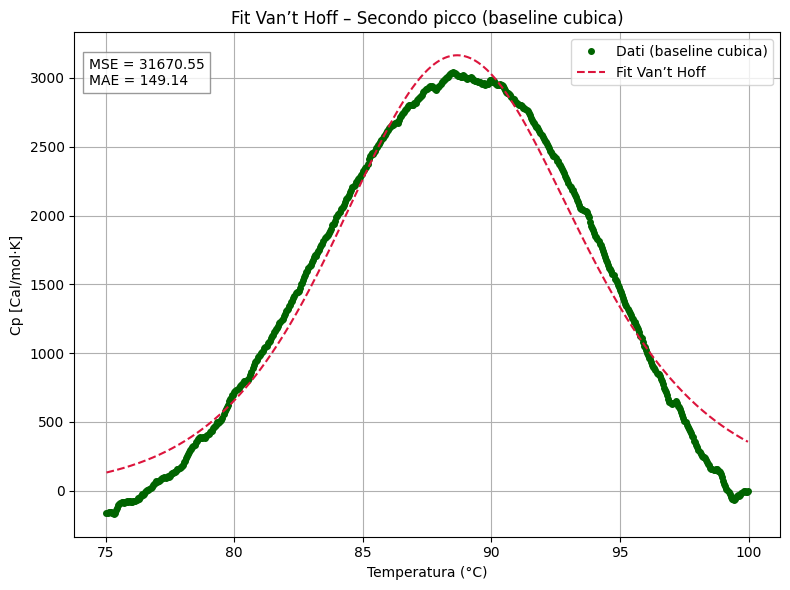

In [48]:
# === Modello Van’t Hoff ===
R = 1.987  # cal/mol·K
def model_vH(T, DH, Tm, Cp_max):
    exponent = -DH / R * (1/T - 1/Tm)
    exponent = np.clip(exponent, -700, 700)
    K = np.exp(exponent)
    return Cp_max * K / (1 + K)**2

# === Fit Van’t Hoff ===
p0_vh2_c = [45000, 363.15, np.max(Cp2)]
bounds_vh2_c = ([10000, 350, 0], [100000, 380, np.max(Cp2) * 10])
popt_vh2_c, pcov_vh2_c = curve_fit(model_vH, T2, Cp2, p0=p0_vh2_c, bounds=bounds_vh2_c, maxfev=20000)

# === Predizione e errori ===
Cp_pred_vh2_c = model_vH(T2, *popt_vh2_c)
mse_vh2_c = mean_squared_error(Cp2, Cp_pred_vh2_c)
mae_vh2_c = mean_absolute_error(Cp2, Cp_pred_vh2_c)

# === Plot ===
T_fit2_c_vh = np.linspace(T2.min(), T2.max(), 500)
Cp_fit2_c_vh = model_vH(T_fit2_c_vh, *popt_vh2_c)

plt.figure(figsize=(8, 6))
plt.plot(T2 - 273.15, Cp2, 'o', color='darkgreen', markersize=4, label="Dati (baseline cubica)")
plt.plot(T_fit2_c_vh - 273.15, Cp_fit2_c_vh, '--', color='crimson', label="Fit Van’t Hoff")
plt.text(0.02, 0.95, f"MSE = {mse_vh2_c:.2f}\nMAE = {mae_vh2_c:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp [Cal/mol·K]")
plt.title("Fit Van’t Hoff – Secondo picco (baseline cubica)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Fit Gauss:

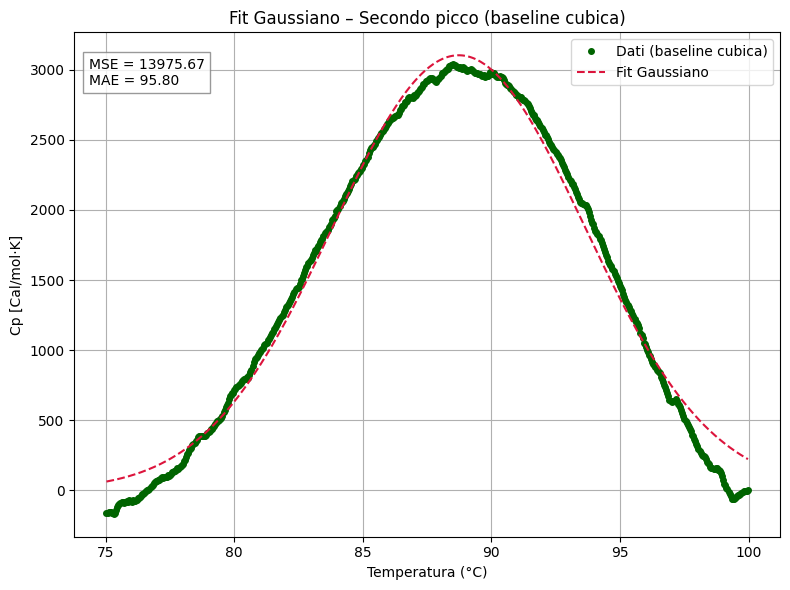

In [49]:
# === Modello Gaussiano ===
def gaussiana(T, A, mu, sigma):
    return A * np.exp(-((T - mu)**2) / (2 * sigma**2))

# === Parametri iniziali ===
A0_2 = np.max(Cp2)
mu0_2 = T2[np.argmax(Cp2)]
sigma0_2 = 5

p0_gauss2_c = [A0_2, mu0_2, sigma0_2]
bounds_gauss2 = ([0, mu0_2 - 10, 1], [A0_2 * 2, mu0_2 + 10, 15])

# === Fit Gaussiano ===
popt_gauss2_c, pcov_gauss2_c = curve_fit(gaussiana, T2, Cp2, p0=p0_gauss2_c, bounds=bounds_gauss2)

# === Predizione e errori ===
Cp_pred_gauss2_c = gaussiana(T2, *popt_gauss2_c)
mse_gauss2_c = mean_squared_error(Cp2, Cp_pred_gauss2_c)
mae_gauss2_c = mean_absolute_error(Cp2, Cp_pred_gauss2_c)

# === Plot ===
T_fit2_c_g = np.linspace(T2.min(), T2.max(), 500)
Cp_fit_gauss2_c_g = gaussiana(T_fit2_c_g, *popt_gauss2_c)

plt.figure(figsize=(8, 6))
plt.plot(T2 - 273.15, Cp2, 'o', color='darkgreen', markersize=4, label="Dati (baseline cubica)")
plt.plot(T_fit2_c_g - 273.15, Cp_fit_gauss2_c_g, '--', color='crimson', label="Fit Gaussiano")
plt.text(0.02, 0.95, f"MSE = {mse_gauss2_c:.2f}\nMAE = {mae_gauss2_c:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp [Cal/mol·K]")
plt.title("Fit Gaussiano – Secondo picco (baseline cubica)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Secondo dataset (fit spezzato):

In [50]:
df_corr.head()

,Temperatura,Cp_corretto,Cp_normalizzato,Cp_baseline_cubica,Cp_finale_cubica,Cp_baseline_spezzata,Cp_finale_spezzata
0,20.003,-0.301771,-3218.891220,-8160.515862,4941.624642,-7306.125876,4087.234655
1,20.018,-0.006626,-70.680655,-8158.300845,8087.620190,-7306.125876,7235.445221
2,20.050,-0.530984,-5663.831449,-8153.574957,2489.743508,-7306.125876,1642.294427
3,20.084,-0.745989,-7957.220834,-8148.552932,191.332098,-7306.125876,-651.094959
4,20.124,-0.773937,-8255.325994,-8142.643656,-112.682338,-7306.125876,-949.200118


### 1° picco:

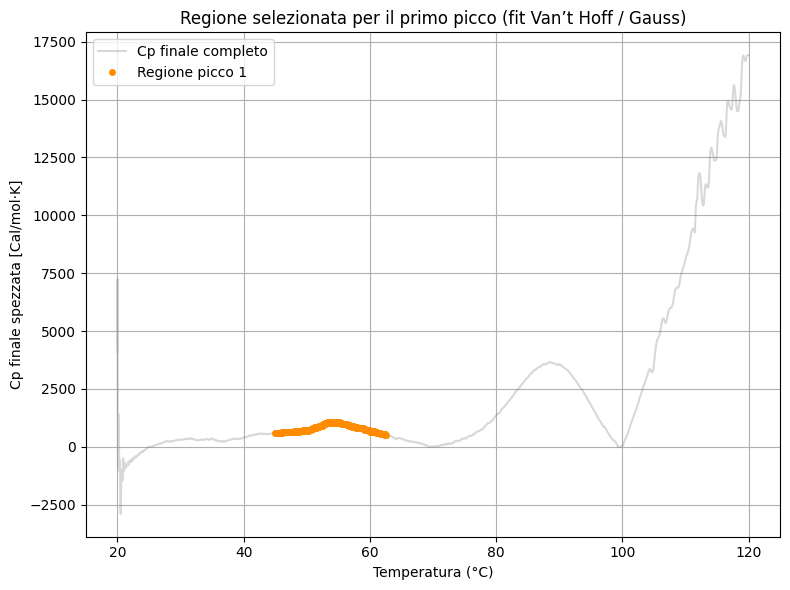

In [51]:
# Estrai dati filtrati (baseline cubica già sottratta)
mask1 = (df_corr["Temperatura"] >= 45) & (df_corr["Temperatura"] <= 62.5)
T1 = df_corr.loc[mask1, "Temperatura"].values + 273.15  # in Kelvin
Cp1 = df_corr.loc[mask1, "Cp_finale_spezzata"].values

# === Plot completo con regione selezionata ===
plt.figure(figsize=(8, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_finale_spezzata"], color='gray', alpha=0.3, label='Cp finale completo')
plt.plot(T1 - 273.15, Cp1, 'o', color='darkorange', markersize=4, label='Regione picco 1')
plt.title("Regione selezionata per il primo picco (fit Van’t Hoff / Gauss)")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp finale spezzata [Cal/mol·K]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Fit Van't Hoff:

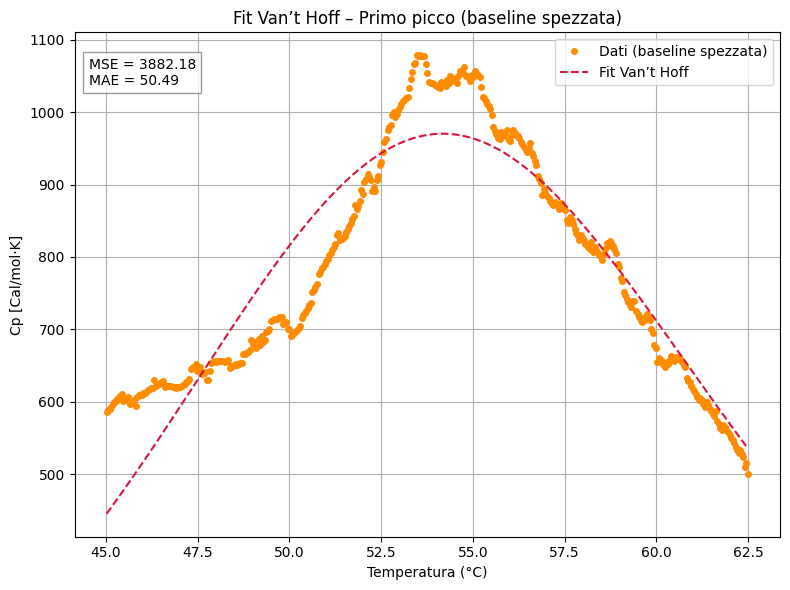

In [52]:

R = 1.987  # cal/mol·K

# --- Modello Van’t Hoff ---
def model_vH(T, DH, Tm, Cp_max):
    exponent = -DH / R * (1/T - 1/Tm)
    exponent = np.clip(exponent, -700, 700)
    K = np.exp(exponent)
    return Cp_max * K / (1 + K)**2

# --- Parametri iniziali e fit ---
p0_vh1 = [30000, 328.15, np.max(Cp1)]
bounds_vh1 = ([10000, 320, 0], [100000, 340, np.max(Cp1) * 10])
popt_vh1, pcov_vh1 = curve_fit(model_vH, T1, Cp1, p0=p0_vh1, bounds=bounds_vh1, maxfev=20000)

# --- Predizione e metrica errore ---
Cp_pred_vh1 = model_vH(T1, *popt_vh1)
mse_vh1 = mean_squared_error(Cp1, Cp_pred_vh1)
mae_vh1 = mean_absolute_error(Cp1, Cp_pred_vh1)

# --- Plot del fit ---
T_fit1_vh = np.linspace(T1.min(), T1.max(), 500)
Cp_fit1_vh = model_vH(T_fit1_vh, *popt_vh1)

plt.figure(figsize=(8, 6))
plt.plot(T1 - 273.15, Cp1, 'o', color='darkorange', markersize=4, label="Dati (baseline spezzata)")
plt.plot(T_fit1_vh - 273.15, Cp_fit1_vh, '--', color='crimson', label="Fit Van’t Hoff")
plt.text(0.02, 0.95, f"MSE = {mse_vh1:.2f}\nMAE = {mae_vh1:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp [Cal/mol·K]")
plt.title("Fit Van’t Hoff – Primo picco (baseline spezzata)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Fit Gauss:

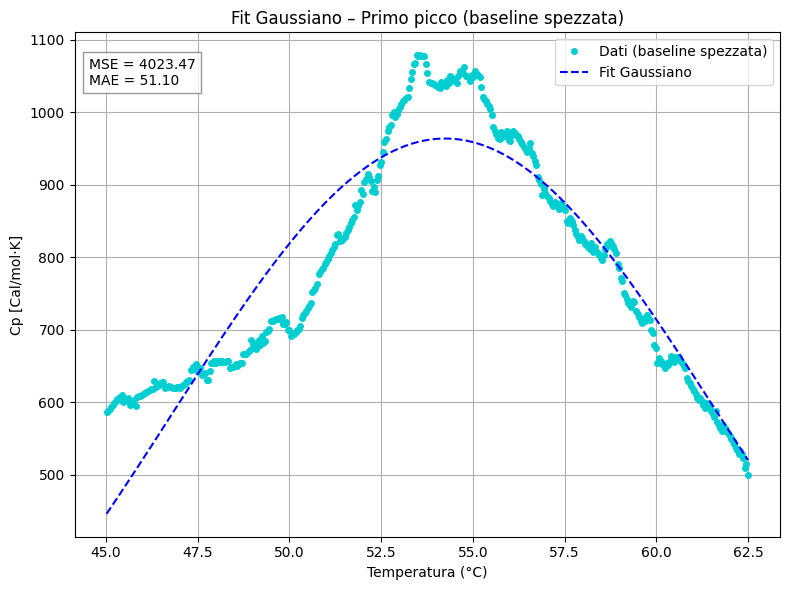

In [53]:
# --- Modello Gaussiano ---
def gaussiana(T, A, mu, sigma):
    return A * np.exp(-((T - mu)**2) / (2 * sigma**2))

# --- Parametri iniziali ---
A0 = np.max(Cp1)
mu0 = T1[np.argmax(Cp1)]
sigma0 = 5
p0_gauss = [A0, mu0, sigma0]
bounds_gauss = ([0, mu0 - 10, 1], [A0 * 2, mu0 + 10, 15])

# --- Fit ---
popt_gauss1, pcov_gauss1 = curve_fit(gaussiana, T1, Cp1, p0=p0_gauss, bounds=bounds_gauss)

# --- Predizione e errore ---
Cp_pred_gauss1 = gaussiana(T1, *popt_gauss1)
mse_gauss1 = mean_squared_error(Cp1, Cp_pred_gauss1)
mae_gauss1 = mean_absolute_error(Cp1, Cp_pred_gauss1)

# --- Plot ---
T_fit1_g = np.linspace(T1.min(), T1.max(), 400)
Cp_fit1_g = gaussiana(T_fit1_g, *popt_gauss1)

plt.figure(figsize=(8, 6))
plt.plot(T1 - 273.15, Cp1, 'o', color='darkturquoise', markersize=4, label="Dati (baseline spezzata)")
plt.plot(T_fit1_g - 273.15, Cp_fit1_g, '--', color='blue', label="Fit Gaussiano")
plt.text(0.02, 0.95, f"MSE = {mse_gauss1:.2f}\nMAE = {mae_gauss1:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp [Cal/mol·K]")
plt.title("Fit Gaussiano – Primo picco (baseline spezzata)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 2° picco:

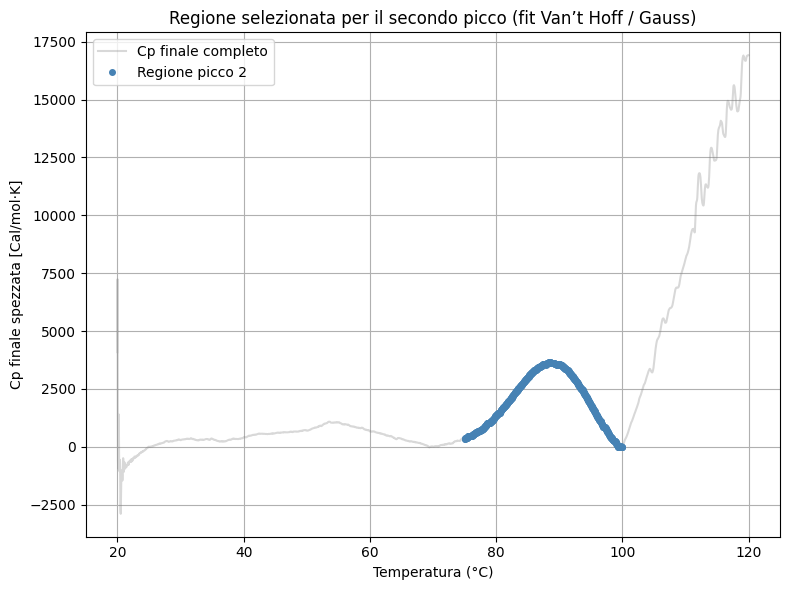

In [54]:
# === Estrai dati filtrati (baseline cubica già sottratta) ===
mask2 = (df_corr["Temperatura"] >= 75) & (df_corr["Temperatura"] <= 100)
T2 = df_corr.loc[mask2, "Temperatura"].values + 273.15  # in Kelvin
Cp2 = df_corr.loc[mask2, "Cp_finale_spezzata"].values

# === Plot completo con regione selezionata ===
plt.figure(figsize=(8, 6))
plt.plot(df_corr["Temperatura"], df_corr["Cp_finale_spezzata"], color='gray', alpha=0.3, label='Cp finale completo')
plt.plot(T2 - 273.15, Cp2, 'o', color='steelblue', markersize=4, label='Regione picco 2')
plt.title("Regione selezionata per il secondo picco (fit Van’t Hoff / Gauss)")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp finale spezzata [Cal/mol·K]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Fit Van't Hoff:

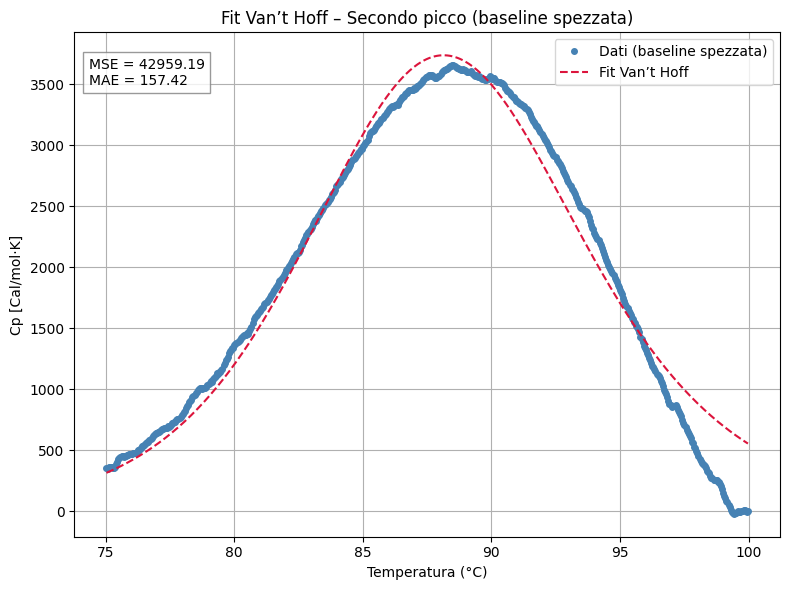

In [55]:
# === Fit Van’t Hoff ===
R = 1.987  # cal/mol·K

def model_vH(T, DH, Tm, Cp_max):
    exponent = -DH / R * (1/T - 1/Tm)
    exponent = np.clip(exponent, -700, 700)
    K = np.exp(exponent)
    return Cp_max * K / (1 + K)**2

p0_vh2 = [60000, 363.15, np.max(Cp2)]
bounds_vh2 = ([10000, 350, 0], [100000, 380, np.max(Cp2) * 10])
popt_vh2, pcov_vh2 = curve_fit(model_vH, T2, Cp2, p0=p0_vh2, bounds=bounds_vh2, maxfev=20000)

Cp_pred_vh2 = model_vH(T2, *popt_vh2)
mse_vh2 = mean_squared_error(Cp2, Cp_pred_vh2)
mae_vh2 = mean_absolute_error(Cp2, Cp_pred_vh2)

T_fit2_vh = np.linspace(T2.min(), T2.max(), 500)
Cp_fit2_vh = model_vH(T_fit2_vh, *popt_vh2)

plt.figure(figsize=(8, 6))
plt.plot(T2 - 273.15, Cp2, 'o', color='steelblue', markersize=4, label="Dati (baseline spezzata)")
plt.plot(T_fit2_vh - 273.15, Cp_fit2_vh, '--', color='crimson', label="Fit Van’t Hoff")
plt.text(0.02, 0.95, f"MSE = {mse_vh2:.2f}\nMAE = {mae_vh2:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp [Cal/mol·K]")
plt.title("Fit Van’t Hoff – Secondo picco (baseline spezzata)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Fit Gauss:

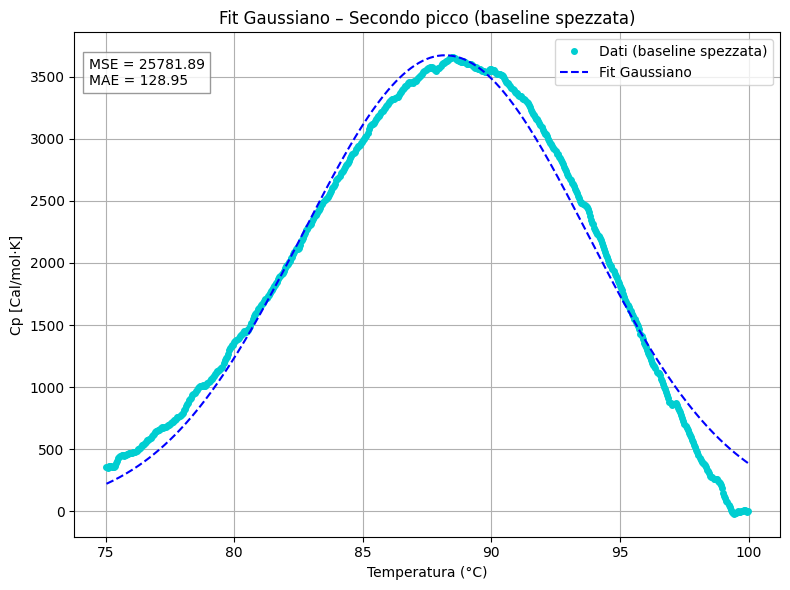

In [56]:
# === Fit Gaussiano ===
def gaussiana(T, A, mu, sigma):
    return A * np.exp(-((T - mu)**2) / (2 * sigma**2))

A0_2 = np.max(Cp2)
mu0_2 = T2[np.argmax(Cp2)]
sigma0_2 = 5
p0_gauss2 = [A0_2, mu0_2, sigma0_2]
bounds_gauss2 = ([0, mu0_2 - 10, 1], [A0_2 * 2, mu0_2 + 10, 15])

popt_gauss2, pcov_gauss2 = curve_fit(gaussiana, T2, Cp2, p0=p0_gauss2, bounds=bounds_gauss2)

Cp_pred_gauss2 = gaussiana(T2, *popt_gauss2)
mse_gauss2 = mean_squared_error(Cp2, Cp_pred_gauss2)
mae_gauss2 = mean_absolute_error(Cp2, Cp_pred_gauss2)

T_fit2_g = np.linspace(T2.min(), T2.max(), 500)
Cp_fit2_g = gaussiana(T_fit2_g, *popt_gauss2)

plt.figure(figsize=(8, 6))
plt.plot(T2 - 273.15, Cp2, 'o', color='darkturquoise', markersize=4, label="Dati (baseline spezzata)")
plt.plot(T_fit2_g - 273.15, Cp_fit2_g, '--', color='blue', label="Fit Gaussiano")
plt.text(0.02, 0.95, f"MSE = {mse_gauss2:.2f}\nMAE = {mae_gauss2:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.xlabel("Temperatura (°C)")
plt.ylabel("Cp [Cal/mol·K]")
plt.title("Fit Gaussiano – Secondo picco (baseline spezzata)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Calcolo dell’entalpia di transizione e della sua incertezza e costruzione del DF finale

Per tutti i modelli (Van’t Hoff e Gaussiana), l’entalpia di transizione $\Delta H$ è stata stimata **numericamente** integrando l’area sotto la curva di fit:

$$
\Delta H = \int_{T_i}^{T_f} C_p^{\text{fit}}(T) \, dT
$$

Questa scelta consente un confronto diretto tra modelli differenti, mantenendo coerenza nel metodo di calcolo.

---

### Incertezza su $\Delta H$: due strategie

#### 1. Modelli Van’t Hoff

Nei modelli di tipo Van’t Hoff, l’incertezza su $\Delta H$ è stata stimata direttamente dalla **matrice di covarianza** del fit:

$$
\sigma_{\Delta H} = \sqrt{\text{pcov}[0, 0]}
$$

dove $\text{pcov}$ è la matrice di covarianza restituita da `curve_fit`, e il parametro $\Delta H$ è il primo elemento del vettore dei parametri ottimizzati.

#### 2. Modelli Gaussiani

Nel caso dei modelli **gaussiani**, l’integrale è calcolato numericamente, ma l’**incertezza su $\Delta H$** è stimata tramite **propagazione degli errori** a partire dai parametri del fit:

$$
\sigma_{\Delta H}^2 =
\left( \frac{\partial \Delta H}{\partial A} \right)^2 \cdot \sigma_A^2 +
\left( \frac{\partial \Delta H}{\partial \sigma} \right)^2 \cdot \sigma_\sigma^2 +
2 \cdot \frac{\partial \Delta H}{\partial A} \cdot \frac{\partial \Delta H}{\partial \sigma} \cdot \text{Cov}(A, \sigma)
$$

con:
- $\frac{\partial \Delta H}{\partial A} = \sigma \cdot \sqrt{2\pi}$
- $\frac{\partial \Delta H}{\partial \sigma} = A \cdot \sqrt{2\pi}$

In forma compatta:

$$
\sigma_{\Delta H} = \sqrt{\nabla^T \cdot \text{Cov}(A, \sigma) \cdot \nabla}
$$

dove $\nabla = \begin{bmatrix} \sigma \sqrt{2\pi} & A \sqrt{2\pi} \end{bmatrix}$ è il **gradiente** della formula analitica rispetto a $A$ e $\sigma$.

---

In entrambi i casi, la stima dell’incertezza rappresenta l’errore **di fit**, non quello dovuto alla scelta della baseline.


### Valutazione dell’incertezza su *T*<sub>m</sub>

L’errore riportato nella colonna **σ<sub>Tₘ</sub>** è la deviazione standard (1 σ)
associata al parametro *T*<sub>m</sub> del fit con la funzione di van’t Hoff.

`scipy.optimize.curve_fit` restituisce la matrice di covarianza `pcov` dei parametri
ottimizzati; l’elemento `pcov[1, 1]` è la varianza stimata di *T*<sub>m</sub>.
Da qui:

$$
\sigma_{T_m} \;=\; \sqrt{\text{pcov}[1,1]}
$$

Questa stima assume:
1. residui gaussiani indipendenti e identicamente distribuiti,  
2. linearizzazione locale del modello intorno al minimo del χ².  

Per misure nanoDSC con buon rapporto segnale/rumore ciò fornisce
incertezze tipiche di **0,05 – 0,20 °C**.  
Se i residui mostrano forte eteroschedasticità o autocorrelazione la
deviazione standard potrebbe essere sottostimata; in tal caso si può
ricorrere a bootstrap dei residui o a un’analisi Monte Carlo, ma per i
dati presenti la stima da `pcov` è considerata adeguata.


In [57]:
# === Costanti ===
R = 1.987  # cal/mol·K
sqrt_2pi = np.sqrt(2 * np.pi)

# === Van’t Hoff ===
DH_vh1_c = np.trapezoid(Cp_fit1_c_vh, T_fit1_c_vh)
DH_vh2_c = np.trapezoid(Cp_fit2_c_vh, T_fit2_c_vh)
DH_vh1_s = np.trapezoid(Cp_fit1_vh, T_fit1_vh)
DH_vh2_s = np.trapezoid(Cp_fit2_vh, T_fit2_vh)

Tm_vh1_c = popt_vh1_c[1]
Tm_vh2_c = popt_vh2_c[1]
Tm_vh1_s = popt_vh1[1]
Tm_vh2_s = popt_vh2[1]

err_DH_vh1_c = np.sqrt(pcov_vh1_c[0, 0])
err_DH_vh2_c = np.sqrt(pcov_vh2_c[0, 0])
err_DH_vh1_s = np.sqrt(pcov_vh1[0, 0])
err_DH_vh2_s = np.sqrt(pcov_vh2[0, 0])

err_Tm_vh1_c = np.sqrt(pcov_vh1_c[1, 1])
err_Tm_vh2_c = np.sqrt(pcov_vh2_c[1, 1])
err_Tm_vh1_s = np.sqrt(pcov_vh1[1, 1])
err_Tm_vh2_s = np.sqrt(pcov_vh2[1, 1])

# === Gaussiane ===
def calcola_DH_gauss(popt, pcov, label, T_fit):
    A, mu, sigma = popt[:3]
    Cp_fit = A * np.exp(-((T_fit - mu)**2) / (2 * sigma**2))
    DH = np.trapezoid(Cp_fit, T_fit)
    
    cov = pcov[np.ix_([0, 2], [0, 2])]
    J = np.array([sigma, A]) * sqrt_2pi
    err_DH = np.sqrt(J @ cov @ J.T)
    err_Tm = np.sqrt(pcov[1, 1])
    return {
        "Modello": label,
        "ΔH (cal/mol)": DH,
        "σ_ΔH": err_DH,
        "Tm (K)": mu,
        "σ_Tm": err_Tm
    }

risultati = [
    {"Modello": "vh1_cubica",   "ΔH (cal/mol)": DH_vh1_c, "σ_ΔH": err_DH_vh1_c, "Tm (K)": Tm_vh1_c, "σ_Tm": err_Tm_vh1_c},
    {"Modello": "vh2_cubica",   "ΔH (cal/mol)": DH_vh2_c, "σ_ΔH": err_DH_vh2_c, "Tm (K)": Tm_vh2_c, "σ_Tm": err_Tm_vh2_c},
    {"Modello": "vh1_spezzata", "ΔH (cal/mol)": DH_vh1_s, "σ_ΔH": err_DH_vh1_s, "Tm (K)": Tm_vh1_s, "σ_Tm": err_Tm_vh1_s},
    {"Modello": "vh2_spezzata", "ΔH (cal/mol)": DH_vh2_s, "σ_ΔH": err_DH_vh2_s, "Tm (K)": Tm_vh2_s, "σ_Tm": err_Tm_vh2_s},
    calcola_DH_gauss(popt_gauss1_c, pcov_gauss1_c, "gauss1_cubica", T_fit1_c_g),
    calcola_DH_gauss(popt_gauss2_c, pcov_gauss2_c, "gauss2_cubica", T_fit2_c_g),
    calcola_DH_gauss(popt_gauss1, pcov_gauss1, "gauss1_spezzata", T_fit1_g),
    calcola_DH_gauss(popt_gauss2, pcov_gauss2, "gauss2_spezzata", T_fit2_g),
]

df_termo = pd.DataFrame(risultati)
df_termo = df_termo.round(2)
df_termo


,Modello,ΔH (cal/mol),σ_ΔH,Tm (K),σ_Tm
0,vh1_cubica,4328.52,1092.68,327.46,0.04
1,vh2_cubica,37897.43,546.67,361.82,0.03
2,vh1_spezzata,13627.14,506.01,327.33,0.05
3,vh2_spezzata,50085.22,455.73,361.29,0.03
4,gauss1_cubica,4318.96,46.21,327.48,0.05
5,gauss2_cubica,37571.05,124.85,361.88,0.02
6,gauss1_spezzata,13632.72,156.02,327.40,0.05
7,gauss2_spezzata,49825.96,183.32,361.35,0.02


Per restare coerenti nell'approccio e nello studio dei dati si è decisio di usare come il modello con baseline spezzata e come errore la scelta di baseline.

In [58]:
# === Estrai solo i due picchi della gauss spezzata e costruisci la riga finale ===
df_gs = df_termo[df_termo["Modello"].isin(["gauss1_spezzata", "gauss2_spezzata"])].copy()

# Controllo di sicurezza
if df_gs.shape[0] != 2:
    raise ValueError(f"Attesi 2 picchi 'gauss*_spezzata', trovati {df_gs.shape[0]}")

# Ordina per Tm (K) crescente: primo picco = Tm1 (più freddo), secondo = Tm2
df_gs = df_gs.sort_values("Tm (K)").reset_index(drop=True)

# Conversione Tm da K a °C (l'errore resta lo stesso numericamente)
TmC = df_gs["Tm (K)"] - 273.15
sigma_TmC = df_gs["σ_Tm"]

row = {
    "Modello": "double_gauss_spezzata",
    "ΔH1 (cal/mol)":   float(df_gs.loc[0, "ΔH (cal/mol)"]),
    "σ_ΔH1 (cal/mol)": float(df_gs.loc[0, "σ_ΔH"]),
    "Tm1 (°C)":        float(TmC.loc[0]),
    "σ_Tm1 (°C)":      float(sigma_TmC.loc[0]),
    "ΔH2 (cal/mol)":   float(df_gs.loc[1, "ΔH (cal/mol)"]),
    "σ_ΔH2 (cal/mol)": float(df_gs.loc[1, "σ_ΔH"]),
    "Tm2 (°C)":        float(TmC.loc[1]),
    "σ_Tm2 (°C)":      float(sigma_TmC.loc[1]),
}

df_gauss_spezzata_finale = pd.DataFrame([row])[
    ["Modello",
     "ΔH1 (cal/mol)", "σ_ΔH1 (cal/mol)", "Tm1 (°C)", "σ_Tm1 (°C)",
     "ΔH2 (cal/mol)", "σ_ΔH2 (cal/mol)", "Tm2 (°C)", "σ_Tm2 (°C)"]
].round(2)

df_gauss_spezzata_finale.head()

,Modello,ΔH1 (cal/mol),σ_ΔH1 (cal/mol),Tm1 (°C),σ_Tm1 (°C),ΔH2 (cal/mol),σ_ΔH2 (cal/mol),Tm2 (°C),σ_Tm2 (°C)
0,double_gauss_spezzata,13632.72,156.02,54.25,0.05,49825.96,183.32,88.2,0.02


Per ciascun campione è stato integrato il calore specifico corretto, usando:

$$
\Delta H = \int_{T_{min}}^{T_{max}} C_p(T) \, dT
$$

La procedura è ripetuta per 2 diversi modelli di baseline: lineare spezzata e cubica.

Per stimare l'incertezza legata alla scelta del modello di baseline, viene calcolata la **deviazione standard** dei valori di ΔH ottenuti con le diverse baseline, assumendo che il contributo maggiore all'errore sia proprio legato a questa scelta.


In [59]:
# === Errori di baseline su ΔH: differenza tra spezzata e cubica ===
df_gs = df_termo[df_termo["Modello"].isin(["gauss1_spezzata", "gauss2_spezzata"])].copy()
df_gc = df_termo[df_termo["Modello"].isin(["gauss1_cubica", "gauss2_cubica"])].copy()

# Controlli
if df_gs.shape[0] != 2 or df_gc.shape[0] != 2:
    raise ValueError(f"Servono esattamente 2 picchi per spezzata e 2 per cubica. "
                     f"Trovati spezzata={df_gs.shape[0]}, cubica={df_gc.shape[0]}.")

# Ordina per Tm (K) così il picco 1 è quello a T più bassa
df_gs = df_gs.sort_values("Tm (K)").reset_index(drop=True)
df_gc = df_gc.sort_values("Tm (K)").reset_index(drop=True)

# Errori baseline = |ΔH_spezzata - ΔH_cubica| per ciascun picco
sigma_baseline_DH1 = float(abs(df_gs.loc[0, "ΔH (cal/mol)"] - df_gc.loc[0, "ΔH (cal/mol)"]))
sigma_baseline_DH2 = float(abs(df_gs.loc[1, "ΔH (cal/mol)"] - df_gc.loc[1, "ΔH (cal/mol)"]))

# Aggiungi al DF finale
df_gauss_spezzata_finale["σ_baseline_ΔH1 (cal/mol)"] = round(sigma_baseline_DH1, 2)
df_gauss_spezzata_finale["σ_baseline_ΔH2 (cal/mol)"] = round(sigma_baseline_DH2, 2)

df_gauss_spezzata_finale.head()

,Modello,ΔH1 (cal/mol),σ_ΔH1 (cal/mol),Tm1 (°C),σ_Tm1 (°C),ΔH2 (cal/mol),σ_ΔH2 (cal/mol),Tm2 (°C),σ_Tm2 (°C),σ_baseline_ΔH1 (cal/mol),σ_baseline_ΔH2 (cal/mol)
0,double_gauss_spezzata,13632.72,156.02,54.25,0.05,49825.96,183.32,88.2,0.02,9313.76,12254.91


#### Ancora sull'incertezza su *T*<sub>m</sub>

L’incertezza totale riportata nella colonna **σ<sub>Tₘ</sub> (°C)** combina:

1. **Errore di fit**  
   $ \sigma_{T_m,\text{fit}} $ ricavato dalla radice della varianza del parametro *T*<sub>m</sub>  
   (elemento `pcov[1, 1]`) fornita da `curve_fit`.

2. **Errore termico dello strumento**  
   TA Instruments specifica per il Nano DSC una stabilità di baseline di ±0.028 µW e un controllo termico a stato solido che garantisce precisione < 0.2 °C :contentReference[oaicite:0]{index=0}.  
   Abbiamo quindi aggiunto **±0.2 °C** in quadratura:


$$
\sigma_{T_{m,\text{tot}}} = \left( \sigma_{T_{m,\text{fit}}}^2 + 0.2 \right)^{1/2}
$$

Questa procedura fornisce un errore **assoluto** su *T*<sub>m</sub>, che include sia la precisione numerica del fit sia la tolleranza termica dichiarata dal produttore.


In [60]:
# === Parametri errore strumentale ===
sigma_instr_Tm = 0.2  # °C

# === Errori baseline su ΔH ===
df_gs = df_termo[df_termo["Modello"].isin(["gauss1_spezzata", "gauss2_spezzata"])].copy()
df_gc = df_termo[df_termo["Modello"].isin(["gauss1_cubica", "gauss2_cubica"])].copy()

# Ordina per Tm (K) crescente
df_gs = df_gs.sort_values("Tm (K)").reset_index(drop=True)
df_gc = df_gc.sort_values("Tm (K)").reset_index(drop=True)

sigma_baseline_DH1 = float(abs(df_gs.loc[0, "ΔH (cal/mol)"] - df_gc.loc[0, "ΔH (cal/mol)"]))
sigma_baseline_DH2 = float(abs(df_gs.loc[1, "ΔH (cal/mol)"] - df_gc.loc[1, "ΔH (cal/mol)"]))

# === Sovrascrivi σ_Tm aggiungendo errore strumentale in quadratura ===
for col in ["σ_Tm1 (°C)", "σ_Tm2 (°C)"]:
    df_gauss_spezzata_finale[col] = np.sqrt(df_gauss_spezzata_finale[col]**2 + sigma_instr_Tm**2)

# === Sovrascrivi σ_ΔH con baseline se più grande ===
if sigma_baseline_DH1 > df_gauss_spezzata_finale.loc[0, "σ_ΔH1 (cal/mol)"]:
    df_gauss_spezzata_finale.loc[0, "σ_ΔH1 (cal/mol)"] = sigma_baseline_DH1

if sigma_baseline_DH2 > df_gauss_spezzata_finale.loc[0, "σ_ΔH2 (cal/mol)"]:
    df_gauss_spezzata_finale.loc[0, "σ_ΔH2 (cal/mol)"] = sigma_baseline_DH2

# Elimina le ultime due colonne (σ_baseline calcolati separatamente)
df_gauss_spezzata_finale = df_gauss_spezzata_finale.drop(
    columns=["σ_baseline_ΔH1 (cal/mol)", "σ_baseline_ΔH2 (cal/mol)"],
    errors="ignore"
)

# Arrotonda il tutto
df_gauss_spezzata_finale = df_gauss_spezzata_finale.round(2)

df_gauss_spezzata_finale.head()




,Modello,ΔH1 (cal/mol),σ_ΔH1 (cal/mol),Tm1 (°C),σ_Tm1 (°C),ΔH2 (cal/mol),σ_ΔH2 (cal/mol),Tm2 (°C),σ_Tm2 (°C)
0,double_gauss_spezzata,13632.72,9313.76,54.25,0.21,49825.96,12254.91,88.2,0.2


### Calcolo di entropia e Gibbs libera

L’entropia di transizione è stata stimata integrando la curva fittata del calore specifico $C_p^{\text{fit}}(T)$ ottenuta dai modelli (Van’t Hoff o Gaussiano), secondo:

$$
\Delta S(T_m) = \int_{T_i}^{T_f} \frac{C_p^{\text{fit}}(T)}{T} \, dT
$$

L’energia libera di Gibbs a 298 K è stata calcolata come:

$$
\Delta G_{298} = \Delta H - T_{\mathrm{ref}} \cdot \Delta S(T_m)
$$

con $T_{\mathrm{ref}} = 298.15\,\mathrm{K}$. Le stesse relazioni sono riportate in Pagano et al., METHODS 64, 43–51 (2013).

**Propagazione degli errori:**


- $\sigma_{\Delta H}$: deviazione standard sull’entalpia calcolata dal fit
- $\sigma_{\Delta S}$: scarto tipo tra i diversi modelli di baseline

$$
\sigma_{\Delta G}^2 = \sigma_{\Delta H}^2 + \left(T_{\mathrm{ref}} \cdot \sigma_{\Delta S} \right)^2
$$

Le colonne $\Delta S$, $\sigma_{\Delta S}$, $\Delta G_{298}$, $\sigma_{\Delta G,298}$, $\Delta G_{310}$ e $\sigma_{\Delta G,310}$ sono state aggiunte al dataframe finale.


In [61]:
# === Calcolo ΔS dai fit gaussiani (baseline spezzata) ===
T_fit1_K = T_fit1_g  # già in Kelvin
T_fit2_K = T_fit2_g  # già in Kelvin

ΔS1_s = np.trapezoid(Cp_fit1_g / T_fit1_K, T_fit1_K)
ΔS2_s = np.trapezoid(Cp_fit2_g / T_fit2_K, T_fit2_K)

# === Calcolo ΔS dai fit gaussiani (baseline cubica) ===
T_fit1_c_K = T_fit1_c_g
T_fit2_c_K = T_fit2_c_g

ΔS1_c = np.trapezoid(Cp_fit_gauss1_c_g / T_fit1_c_K, T_fit1_c_K)
ΔS2_c = np.trapezoid(Cp_fit_gauss2_c_g / T_fit2_c_K, T_fit2_c_K)

# === Errore ΔS come differenza tra baseline ===
σΔS1 = abs(ΔS1_s - ΔS1_c)
σΔS2 = abs(ΔS2_s - ΔS2_c)

# === Salva ΔS e σΔS nel DataFrame ===
df_gauss_spezzata_finale["ΔS1 (cal/mol·K)"] = ΔS1_s
df_gauss_spezzata_finale["ΔS2 (cal/mol·K)"] = ΔS2_s
df_gauss_spezzata_finale["σ_ΔS1 (cal/mol·K)"] = σΔS1
df_gauss_spezzata_finale["σ_ΔS2 (cal/mol·K)"] = σΔS2

# === ΔG a 298 K ===
df_gauss_spezzata_finale["ΔG1_298 (cal/mol)"] = df_gauss_spezzata_finale["ΔH1 (cal/mol)"] - 298.15 * ΔS1_s
df_gauss_spezzata_finale["ΔG2_298 (cal/mol)"] = df_gauss_spezzata_finale["ΔH2 (cal/mol)"] - 298.15 * ΔS2_s

# === ΔG a 310 K ===
df_gauss_spezzata_finale["ΔG1_310 (cal/mol)"] = df_gauss_spezzata_finale["ΔH1 (cal/mol)"] - 310.15 * ΔS1_s
df_gauss_spezzata_finale["ΔG2_310 (cal/mol)"] = df_gauss_spezzata_finale["ΔH2 (cal/mol)"] - 310.15 * ΔS2_s

# === Propagazione errori ΔG ===
df_gauss_spezzata_finale["σ_ΔG1_298 (cal/mol)"] = np.sqrt(df_gauss_spezzata_finale["σ_ΔH1 (cal/mol)"]**2 + (298.15 * σΔS1)**2)
df_gauss_spezzata_finale["σ_ΔG2_298 (cal/mol)"] = np.sqrt(df_gauss_spezzata_finale["σ_ΔH2 (cal/mol)"]**2 + (298.15 * σΔS2)**2)

df_gauss_spezzata_finale["σ_ΔG1_310 (cal/mol)"] = np.sqrt(df_gauss_spezzata_finale["σ_ΔH1 (cal/mol)"]**2 + (310.15 * σΔS1)**2)
df_gauss_spezzata_finale["σ_ΔG2_310 (cal/mol)"] = np.sqrt(df_gauss_spezzata_finale["σ_ΔH2 (cal/mol)"]**2 + (310.15 * σΔS2)**2)

# Arrotonda e reset indice
df_gauss_spezzata_finale = df_gauss_spezzata_finale.round(2).reset_index(drop=True)

display(df_gauss_spezzata_finale)


,Modello,ΔH1 (cal/mol),σ_ΔH1 (cal/mol),Tm1 (°C),σ_Tm1 (°C),ΔH2 (cal/mol),σ_ΔH2 (cal/mol),Tm2 (°C),σ_Tm2 (°C),ΔS1 (cal/mol·K),...,σ_ΔS1 (cal/mol·K),σ_ΔS2 (cal/mol·K),ΔG1_298 (cal/mol),ΔG2_298 (cal/mol),ΔG1_310 (cal/mol),ΔG2_310 (cal/mol),σ_ΔG1_298 (cal/mol),σ_ΔG2_298 (cal/mol),σ_ΔG1_310 (cal/mol),σ_ΔG2_310 (cal/mol)
0,double_gauss_spezzata,13632.72,9313.76,54.25,0.21,49825.96,12254.91,88.2,0.2,41.69,...,28.49,34.09,1203.92,8694.58,703.68,7039.11,12606.09,15920.88,12838.98,16185.06


In [62]:
import os
# === Salva solo se non esiste già ===
filename = "cMYC_unfolding_picture.csv"
if not os.path.exists(filename):
    df_gauss_spezzata_finale.to_csv(filename, index=False)
    print(f"File salvato come: {filename}")
else:
    print(f" Il file '{filename}' esiste già. Non è stato sovrascritto.")

 Il file 'cMYC_unfolding_picture.csv' esiste già. Non è stato sovrascritto.
